In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import hiddenlayer as hl

## BottleNeck Layers

In [2]:
class BottleNeck(nn.Module):
    def __init__(self, filters, s):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(filters[0])
        self.conv_x_1 = nn.Conv2d(in_channels=filters[0], out_channels=filters[1],
                                  kernel_size=(1,1), stride=s, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(filters[1])
        self.conv_x_2 = nn.Conv2d(in_channels=filters[1], out_channels=filters[1],
                                  kernel_size=(3,3), stride=1, padding=1, bias=False)
        
        self.bn3 = nn.BatchNorm2d(filters[1])
        self.conv_x_3 = nn.Conv2d(in_channels=filters[1], out_channels=filters[2],
                                 kernel_size=(1,1), stride=1, padding=0, bias=False)
    def forward(self, x):
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv_x_1(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv_x_2(x)
        x = self.bn3(x)
        x = F.relu(x)
        out = self.conv_x_3(x)
        
        return out

## Identtiy Mapping

In [3]:
class IdentityMapping(nn.Module):
    def __init__(self, filters, stride):
        super().__init__()
        self.identity_filters = filters[-1:]+filters[1:]
        self.bottleneck = BottleNeck(self.identity_filters, stride)
    def forward(self, x):
        x_id = x
        x = self.bottleneck(x)
        
        out = torch.add(x, x_id)
        return out

## Projection Mapping

In [4]:
class ProjectionMapping(nn.Module):
    def __init__(self, filters, stride):
        super().__init__()
        self.bottleneck = BottleNeck(filters, stride)
        
        self.bn_proj = nn.BatchNorm2d(filters[0])
        self.projection = nn.Conv2d(in_channels=filters[0], out_channels=filters[2],
                                  kernel_size=(1,1), stride=stride, padding=0, bias=False)
    def forward(self, x):
        x_proj = x
        x = self.bottleneck(x)
        
        x_proj = self.bn_proj(x_proj)
        x_proj = F.relu(x_proj)
        x_proj = self.projection(x_proj)
        
        out = torch.add(x, x_proj)
        return out

## ResNet

In [5]:
class ResNetV2(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64,
                                  kernel_size=(7,7), stride=2, padding=(3,3))
        self.layer1 = self.get_layers([64, 64, 256], 1, layers[0])
        self.layer2 = self.get_layers([256, 128, 512], 2, layers[1])
        self.layer3 = self.get_layers([512, 256, 1024], 2, layers[2])
        self.layer4 = self.get_layers([1024, 512, 2048], 2, layers[3])
        
        self.post_bn = nn.BatchNorm2d(2048)
        
        self.avg_pool = nn.AvgPool2d(kernel_size=(2,2))
        
        self.linear = nn.Linear(in_features=2048, out_features=1000)
        
    def get_layers(self, filters, s, num_layers):
        layer = [ProjectionMapping(filters, s)]

        for i in range(num_layers-1):
            layer.append(IdentityMapping(filters, 1))
            
        return nn.Sequential(*layer)
    
    def forward(self, x):
        x = self.conv_1(x)
        x = F.max_pool2d(x, kernel_size=(3,3), stride=2, padding=1)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.post_bn(x)
        x = F.relu(x)
        
        x = F.adaptive_avg_pool2d(x, output_size=(1, 1)) #global average pooling
        x = x.view(-1)
        out = self.linear(x)
        return out

In [6]:
resnetv2 = ResNetV2([3,4,6,3])

In [7]:
resnetv2

ResNetV2(
  (conv_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (layer1): Sequential(
    (0): ProjectionMapping(
      (bottleneck): BottleNeck(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_x_1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_x_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_x_3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn_proj): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (projection): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): IdentityMapping(
      (bottleneck): BottleNeck(
        (bn1): BatchNorm2d(25

## Visualizing the ResNetV2 Architecture

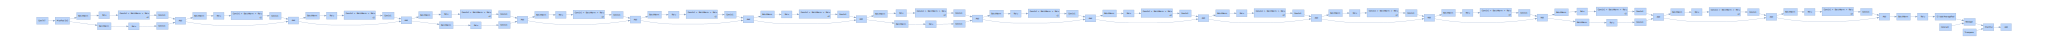

In [18]:
hl_graph = hl.build_graph(resnetv2, torch.zeros([1, 3, 224, 224]))
hl_graph.theme = hl.graph.THEMES["blue"].copy() 
hl_graph

In [19]:
hl_graph.save("architecture")

In [10]:
data = torch.randn([1,3, 224,224])

In [11]:
data.shape

torch.Size([1, 3, 224, 224])

In [12]:
y = resnetv2(data)

In [13]:
y.shape

torch.Size([1000])

In [20]:
from torchviz import make_dot

In [23]:
make_dot(y, params = dict(resnetv2.named_parameters())).render("arch", format="png")

'arch.png'